# Importações

In [1]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import gc, copy, joblib
from torch import nn, optim, device, set_grad_enabled, cuda, is_tensor, save, cat
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pprint as pp
import joblib

# Carregando dados

In [2]:
with open('objetos/entradas.npy', 'rb') as f:
    entradas = np.load(f)
with open('objetos/saidas.npy', 'rb') as f:
    saidas = np.load(f)

In [3]:
print(entradas.shape)
print(entradas[:5, :5])

(66558, 106)
[[-0.47967377 -0.89007582 -0.12937189  0.          0.        ]
 [-0.74948711 -0.90783724 -0.3149337   0.          0.        ]
 [-0.97949191 -0.90151503 -0.41863003  0.          0.        ]
 [-0.74948711 -0.89688445 -0.25711433  0.          0.        ]
 [-0.93083705 -0.88805976 -0.30959316  0.          0.        ]]


# Definindo modelo

In [4]:
# Classificador pytorch
class NNRegressor(nn.Module):
    
    def __init__(self,
                 input_size,
                 outnorm,
                 lr=1e-3,
                 acc_tol = 0.15,
                 verbose=False
                ):
        super(NNRegressor, self).__init__()
        
        self.verbose = verbose
        self.outnorm = outnorm
        
        if cuda.is_available():
            self.device = device('cuda')
            device_str = 'gpu'
        else:
            self.device = device('cpu')
            device_str = 'cpu'
            
        if self.verbose:
            print('Rodando em %s...' % device_str)
            
        self.architecture_Gen = nn.Sequential(
            nn.Linear(80, 4),
            nn.LeakyReLU()
        ).to(self.device)
        
        self.architecture_week = nn.Sequential(
            nn.Linear(23, 4),
            nn.LeakyReLU()
        ).to(self.device)
        
        self.architecture = nn.Sequential(
            nn.Linear(11, 48),
            nn.LeakyReLU(),
            nn.Linear(48, 192),
            nn.LeakyReLU(),
            nn.Linear(192, 48),
            nn.LeakyReLU(),
            nn.Linear(48, 1)
        ).to(self.device)
        
        self.init_weights()
            
        self.criterion = nn.MSELoss().to(self.device)
        self.learning_rate = lr
        
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        self.to(self.device)
        
    def forward(self, X):
        A = X[:, 0:3]
        B = X[:, 3:83]
        C = X[:, 83:106]
        Xb = self.architecture_Gen(B)
        Xc = self.architecture_week(C)
        Xx = cat((A, Xb, Xc), 1)
        return self.architecture(Xx)
    
    def init_weights(self):
        for layer in self.architecture:
            if isinstance(layer, nn.Linear):
                layer.weight = nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.0)
                
        for layer in self.architecture_Gen:
            if isinstance(layer, nn.Linear):
                layer.weight = nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.0)
                
        for layer in self.architecture_week:
            if isinstance(layer, nn.Linear):
                layer.weight = nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.0)
                
    def fit(self, loaders, n_epochs=100):
        self.train_loss_history = []
        self.train_r2_history = []
        self.train_epm_history = [] # epm: erro percentual médio
        self.train_acc_history = [] # acc: acurácia(nº de acertos dentro de 15% de margem) 
        
        self.test_loss_history = []
        self.test_r2_history = []
        self.test_epm_history = []
        self.test_acc_history = []
        
        self.best_r2 = float('-inf')
        self.loss_best_r2 = float('inf')
        self.epoch_best_r2 = None
        self.best_weights = None
        self.epm_best_r2 = float('inf')
        self.acc_best_r2 = float('-inf')
        
        for epoch in range(n_epochs):
            gc.collect()
            
            # Treinamento
            self.train()
            
            self.optimizer.zero_grad()
            
            r2_avg = 0
            loss_avg = 0
            epm_avg = 0
            acc_avg = 0
            n = 0
            for inputs, values in loaders['train']:
                    inputs = inputs.to(self.device).float()
                    values = values.to(self.device).float()
                    
                    set_grad_enabled(True)
                    output = self.forward(inputs)
                    
                    pred = output.data.cpu().numpy()
                    values_cpu = values.data.cpu().numpy()
                    r2= r2_score(values_cpu, pred)
                    loss = self.criterion(output, values)
                    
                    loss_avg += loss.item()
                    r2_avg += r2
                    epm_avg += erro_percent_medio(pred, values_cpu, self.outnorm)
                    acc_avg += acuracia(pred, values_cpu, self.outnorm, acc_tol)
                    n += 1
                    
                    loss.backward()
                    self.optimizer.step()
                    
            loss_avg /= n
            r2_avg /= n
            epm_avg /= n
            acc_avg /= n
            
            self.train_loss_history.append(loss_avg)
            self.train_r2_history.append(r2_avg)
            self.train_epm_history.append(epm_avg)
            self.train_acc_history.append(acc_avg)
                    
            # Teste
            self.eval()
            
            r2_avg = 0
            loss_avg = 0
            epm_avg = 0
            acc_avg = 0
            n = 0
            for inputs, values in loaders['test']:
                    inputs = inputs.to(self.device).float()
                    values = values.to(self.device).float()
                    
                    set_grad_enabled(False)
                    output = self.forward(inputs)
                    
                    pred = output.data.cpu().numpy()
                    values_cpu = values.data.cpu().numpy()
                    r2= r2_score(values_cpu, pred)
                    loss = self.criterion(output, values)
                    
                    loss_avg += loss.item()
                    r2_avg += r2
                    epm_avg += erro_percent_medio(pred, values_cpu, self.outnorm)
                    acc_avg += acuracia(pred, values_cpu, self.outnorm, acc_tol)
                    n += 1
            loss_avg /= n
            r2_avg /= n
            epm_avg /= n
            acc_avg /= n
            
            self.test_loss_history.append(loss_avg)
            self.test_r2_history.append(r2_avg)
            self.test_epm_history.append(epm_avg)
            self.test_acc_history.append(acc_avg)
            
            if self.verbose:
                msg = 'Época %d de %d (r2=%.4f, loss=%.4f)'
                print(msg % (epoch+1, n_epochs, r2_avg, loss_avg))
            
            if r2_avg > self.best_r2:
                self.best_r2 = r2_avg
                self.loss_best_r2 = loss_avg
                self.epoch_best_r2 = epoch
                self.best_weights = copy.deepcopy(self.state_dict())
                self.epm_best_r2 = epm_avg
                self.acc_best_r2 = acc_avg
                
                if self.verbose:
                    print('\tMelhor resultado encontrado.')
                
        self.load_state_dict(self.best_weights)
        
    def predict(self, loader):
        predictions = None
        gc.collect()
        
        self.eval()
            
        r2_avg = 0
        loss_avg = 0
        epm_avg = 0
        acc_avg = 0
        n = 0
        
        for inputs, values in loader:
                inputs = inputs.to(self.device).float()
                values = values.to(self.device).float()

                set_grad_enabled(False)
                output = self.forward(inputs)

                pred = output.data.cpu().numpy()
                values_cpu = values.data.cpu().numpy()
                r2= r2_score(values_cpu, pred)
                loss = self.criterion(output, values)
                
                predict = pred.reshape(pred.shape[0])
                if predictions is None:
                    predictions = predict
                else:
                    predictions = np.concatenate((predictions, predict))

                loss_avg += loss.item()
                r2_avg += r2
                epm_avg += erro_percent_medio(pred, values_cpu, self.outnorm)
                acc_avg += acuracia(pred, values_cpu, self.outnorm, acc_tol)
                n += 1
        loss_avg /= n
        r2_avg /= n
        epm_avg /= n
        acc_avg /= n
        
        return np.array(predictions), loss_avg, r2_avg, epm_avg, acc_avg
        
    def get_stats(self):
        stats = {
            'train': {
                'r2_hist': self.train_r2_history,
                'loss_hist': self.train_loss_history,
                'epm_hist': self.train_epm_history,
                'acc_hist': self.train_acc_history,
            },
            'test': {
                'r2_hist': self.test_r2_history,
                'loss_hist': self.test_loss_history,
                'epm_hist': self.test_epm_history,
                'acc_hist': self.test_acc_history,
            },
            'best': {
                'r2': self.best_r2,
                'epoch': self.epoch_best_r2,
                'loss': self.loss_best_r2,
                'epm': self.epm_best_r2,
                'acc': self.acc_best_r2,
            }
        }
        return stats
    
    def get_weights(self):
        return copy.deepcopy(self.state_dict())
    
    def get_full_state(self):
        state = {
            'weights': copy.deepcopy(self.state_dict()),
            'optim': copy.deepcopy(self.optimizer.state_dict())
        }
        
        return state
        
    def save_weights(self, filename):
        save(self.get_weights(), filename)
        
    def save_full_state(self, filename):
        save(self.get_full_state(), filename)

class Dataset:
    def __init__ (self, data, target):
        self.data = data
        self.target = target

    def __len__ (self):
        return len(self.data)

    def __getitem__ (self, idx):
        if is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx], self.target[idx]
    
def get_loaders(data, target, test_size=0.15, batch_size=50, seed=42):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        data,
        target,
        test_size=test_size,
        random_state=seed
    )

    train = Dataset(Xtrain, Ytrain)
    val = Dataset(Xtest, Ytest)

    loaders = {
        'train': DataLoader(train, batch_size=batch_size, shuffle=True),
        'test': DataLoader(val, batch_size=batch_size, shuffle=False),
    }

    return loaders, Xtrain, Xtest, Ytrain, Ytest

def get_loadersCV(Xtrain, Xtest, Ytrain, Ytest, batch_size=50):
    train = Dataset(Xtrain, Ytrain)
    val = Dataset(Xtest, Ytest)

    loaders = {
        'train': DataLoader(train, batch_size=batch_size, shuffle=True),
        'test': DataLoader(val, batch_size=batch_size, shuffle=False),
    }

    return loaders

def get_loader(Xtest, Ytest, shuffle=False, batch_size=50):
    data = Dataset(Xtest, Ytest)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)

def plota_historico(x, ytrain, ytest, title):
    plt.plot(x, ytrain, label='Treinamento')
    plt.plot(x, ytest, label='Teste')
    plt.grid()
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
def erro_percent_medio(y_pred, y_real, outnorm):

    Yreal = outnorm.inverse_transform(y_real)
    Ypred = outnorm.inverse_transform(y_pred)

    return np.average(np.abs(Ypred-Yreal)/Yreal)*100

def acuracia(y_pred, y_real, outnorm, acc_tol):

    Yreal = outnorm.inverse_transform(y_real)
    Ypred = outnorm.inverse_transform(y_pred)

    return np.count_nonzero(np.abs(Ypred-Yreal) < acc_tol*Yreal)/len(Yreal)


#### Parâmetros

In [5]:
test_size = 0.15
batch_size = 1024
lr = 1e-4
verbose = False
n_epochs = 7500
arqNormalizador = 'objetos/outnorm.o'
validate = True
save_training = True
seed = 42
acc_tol = 0.15 # Tolerância de erro usada no cálculo da acurácia: Default +/-15%

In [6]:
input_size = entradas.shape[1]
outnorm = joblib.load(arqNormalizador)
loaders,_,_,_,_ = get_loaders(
    entradas,
    saidas,
    test_size=test_size,
    batch_size=batch_size,
    seed=seed
)
modelo = NNRegressor(input_size, outnorm, lr=lr, acc_tol=acc_tol, verbose=verbose)
modelo.fit(loaders, n_epochs)
stats = modelo.get_stats()

In [7]:
print('        Melhor r2: %.3f' % stats['best']['r2'])
print(' Loss na ocasição: %.3f' % stats['best']['loss'])
print('  epm na ocasição: %.2f%%' % stats['best']['epm'])
print('  acc na ocasição: %.2f' % stats['best']['acc'])
print('Ocorrida na época: %d' % stats['best']['epoch'])

        Melhor r2: 0.552
 Loss na ocasição: 0.445
  epm na ocasição: 11.58%
  acc na ocasição: 0.75
Ocorrida na época: 5650


# Analisando o treinamento do modelo

In [8]:
# Dados para plot do treinamento
r2_tr = stats['train']['r2_hist']
loss_tr = stats['train']['loss_hist']
epm_tr = stats['train']['epm_hist']
acc_tr = stats['train']['acc_hist']

r2_ts = stats['test']['r2_hist']
loss_ts = stats['test']['loss_hist']
epm_ts = stats['test']['epm_hist']
acc_ts = stats['test']['acc_hist']
x = list(range(len(r2_tr)))

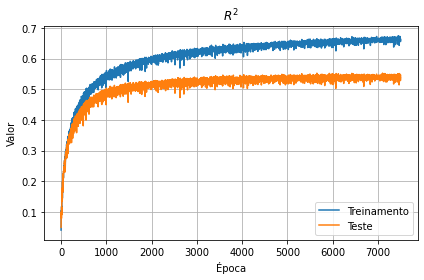

In [9]:
plota_historico(x, r2_tr, r2_ts, r'$R^{2}$')

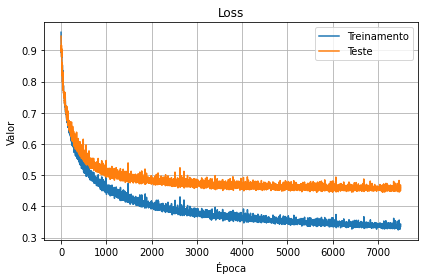

In [10]:
plota_historico(x, loss_tr, loss_ts, 'Loss')

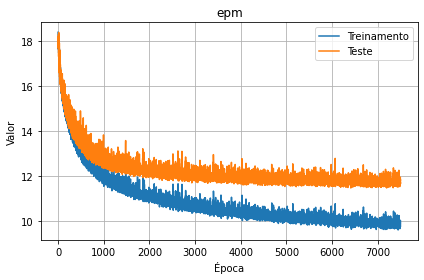

In [11]:
plota_historico(x, epm_tr, epm_ts, 'epm')

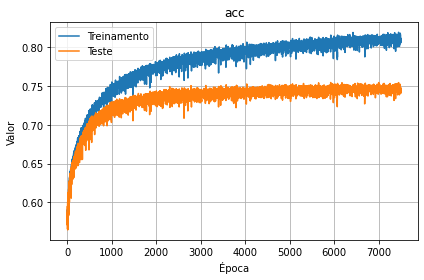

In [12]:
plota_historico(x, acc_tr, acc_ts, 'acc')

# Validando o modelo

In [13]:
if validate:
    # Separa base em parcela para em validação cruzada e para teste
    entradasCV, entradasTst, saidasCV, saidasTst = train_test_split(
        entradas,
        saidas,
        test_size=test_size,
        random_state=seed
    )

    # Realiza validação cruzada
    skf = KFold(n_splits=5, shuffle=True)
    skf.get_n_splits(entradasCV, saidasCV)

    stats = []
    i = 1
    best_model = None
    best_r2 = 0
    best_epm = 0
    best_acc = 0
    for train_index, val_index in skf.split(entradasCV, saidasCV):
        print('Avaliando fold %d...' % i)
        X_train, X_val = entradasCV[train_index], entradasCV[val_index]
        y_train, y_val = saidasCV[train_index], saidasCV[val_index]

        input_size = X_train.shape[1]

        loaders = get_loadersCV(X_train, X_val, y_train, y_val, batch_size=batch_size)
        modelo = NNRegressor(input_size, outnorm, lr=lr, acc_tol=acc_tol, verbose=False)
        modelo.fit(loaders, n_epochs)
        sts = modelo.get_stats()
        stats.append(sts)

        if sts['best']['r2'] > best_r2:
            best_r2 = sts['best']['r2']
            best_epm = sts['best']['epm']
            best_acc = sts['best']['acc']
            best_model = copy.deepcopy(modelo)

        i += 1

    print('Melhor R2 encontrado: %.3f, com acc: %.2f e com epm: %.2f%%' % (best_r2,best_acc,best_epm))

    list_r2 = []
    list_loss = []
    list_epm = []
    list_acc = []
    for fold in stats:
        list_r2.append(fold['best']['r2'])
        list_loss.append(fold['best']['loss'])
        list_epm.append(fold['best']['epm'])
        list_acc.append(fold['best']['acc'])

    print('R2:')
    print('\tMédia: %.3f' % np.mean(list_r2))
    print('\t Var.: %.5f' % np.var(list_r2))

    print('Loss:')
    print('\tMédia: %.3f' % np.mean(list_loss))
    print('\t Var.: %.5f' % np.var(list_loss))
    
    print('epm:')
    print('\tMédia: %.3f' % np.mean(list_epm))
    print('\t Var.: %.5f' % np.var(list_epm))
    
    print('acc:')
    print('\tMédia: %.3f' % np.mean(list_acc))
    print('\t Var.: %.5f' % np.var(list_acc))

    # Testando melhor modelo na base de testes
    loader = get_loader(entradasTst, saidasTst, batch_size=len(entradasTst))
    pred, loss, r2, epm, acc = best_model.predict(loader)

    print('  R2: %.3f' % r2)
    print('Loss: %.3f' % loss)
    print(' epm: %.2f%%' % epm)
    print(' acc: %.2f' % acc)

Avaliando fold 1...
Avaliando fold 2...
Avaliando fold 3...
Avaliando fold 4...
Avaliando fold 5...
Melhor R2 encontrado: 0.541, com acc: 0.75 e com epm: 11.73%
R2:
	Média: 0.535
	 Var.: 0.00002
Loss:
	Média: 0.459
	 Var.: 0.00007
epm:
	Média: 11.675
	 Var.: 0.00714
acc:
	Média: 0.749
	 Var.: 0.00002
  R2: 0.540
Loss: 0.459
 epm: 11.60%
 acc: 0.75


# Salvando o modelo

In [14]:
if save_training:
    # Treinando com todos dados novamente
    input_size = entradas.shape[1]

    loaders, Xtrain, Xtest, Ytrain, Ytest = get_loaders(
        entradas,
        saidas,
        test_size=test_size,
        batch_size=batch_size,
        seed=seed
    )
    modelo = NNRegressor(input_size, outnorm, lr=lr, acc_tol=acc_tol, verbose=verbose)
    modelo.fit(loaders, n_epochs)
    stats = modelo.get_stats()

    print('R2:   %.3f' % stats['best']['r2'])
    print('Loss: %.3f' % stats['best']['loss'])
    print('epm:  %.2f%%' % stats['best']['epm'])
    print('acc:  %.2f' % stats['best']['acc'])

    # Salvando
#     modelo.save_weights('objetos/pesos.p')
#     modelo.save_full_state('objetos/completo.p')

R2:   0.552
Loss: 0.446
epm:  11.62%
acc:  0.75
